<br>
<section style="font-family:Times New Roman"><br>
    <strong style= "font-weight: bold; color:#0e1a40; font-size:35px;"><i>LGBM | Optuna | Insurance Policy | Py</i></strong><br><br>
    <b style= "font-weight: bold; color:#000000; font-size:20px;"> By: <i>Kheirallah Samaha</i></b><br><br>
    <b style= "font-weight: bold; color:#000000; font-size:17px;"> Date: Dec-03-2024</b>
</section>

**Dataset Description:**
<br>
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Insurance Premium Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.
<br>
<br>
**Files:**
<br>
<br>
**train.csv -**  the training dataset; Premium Amount is the continuous target.   
**test.csv -** the test dataset; your objective is to predict target Premium Amount for each row.   
**sample_submission.csv -** a sample submission file in the correct format.   

## Import libraries

In [55]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from datetime import datetime
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    RepeatedKFold,
    cross_val_score,
    train_test_split,
)

import shap


def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("fast")

## Load the Datasets

In [2]:
train_df_imp = pd.read_csv("train.csv")
test_df_imp = pd.read_csv("test.csv")
sample_submission = pd.read_csv("submission.csv")

In [3]:
train_df_imp.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
train_df_imp.nunique().sort_values()

Gender                        2
Smoking Status                2
Policy Type                   3
Marital Status                3
Occupation                    3
Location                      3
Property Type                 3
Customer Feedback             3
Exercise Frequency            4
Education Level               4
Number of Dependents          5
Insurance Duration            9
Previous Claims              10
Vehicle Age                  20
Age                          47
Credit Score                550
Premium Amount             4794
Annual Income             88593
Policy Start Date        167381
Health Score             532657
id                      1200000
dtype: int64

In [5]:
train_df_imp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [6]:
def exrtact_date(df):
    df.columns = df.columns.str.replace(" ", "_")
    df = df.drop("id", axis="columns")
    df["Policy_Start_Date"] = pd.to_datetime(df["Policy_Start_Date"])
    df["Year"] = df["Policy_Start_Date"].dt.year.astype("category")
    df["Month"] = df["Policy_Start_Date"].dt.month.astype("category")
    df["Day"] = df["Policy_Start_Date"].dt.day.astype("category")
    df["Month_name"] = df["Policy_Start_Date"].dt.month_name()
    df["Day_of_week"] = df["Policy_Start_Date"].dt.day_name()
    df["Annual_Income_Health_Score_Ratio"] = df["Health_Score"] / df["Annual_Income"]
    df["Annual_Income_Age_Ratio"] = df["Annual_Income"] / df["Age"]
    df["Credit_Age"] = df["Credit_Score"] / df["Age"]
    df["Vehicle_Age_Insurance_Duration"] = df["Vehicle_Age"] / df["Insurance_Duration"]
    df["Policy_Start_Date"] = df["Policy_Start_Date"].dt.date
    return df

In [7]:
train_df = exrtact_date(train_df_imp)
test_df = exrtact_date(test_df_imp)

In [8]:
test_df.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,Age,Annual_Income,Number_of_Dependents,Health_Score,Previous_Claims,Vehicle_Age,Credit_Score,Insurance_Duration,Annual_Income_Health_Score_Ratio,Annual_Income_Age_Ratio,Credit_Age,Vehicle_Age_Insurance_Duration
count,787511.00,770140.00,726870.00,750551.00,557198.00,799997.00,708549.00,799998.00,722335.00,758132.00,697541.00,799995.00
mean,41.14,32803.87,2.01,25.61,1.00,9.57,592.90,5.02,0.01,906.46,16.38,3.00
std,13.54,32201.06,1.42,12.21,0.98,5.77,150.12,2.59,0.07,1016.71,7.73,3.52
min,18.00,2.00,0.00,1.65,0.00,0.00,300.00,1.00,0.00,0.04,4.69,0.00
25%,30.00,8048.00,1.00,15.92,0.00,5.00,468.00,3.00,0.00,206.24,10.79,1.00
50%,41.00,23981.00,2.00,24.58,1.00,10.00,595.00,5.00,0.00,583.23,14.40,2.00
75%,53.00,44660.00,3.00,34.52,2.00,15.00,721.00,7.00,0.00,1215.24,20.21,3.50
max,64.00,149997.00,4.00,57.96,9.00,19.00,849.00,9.00,21.61,8331.89,47.17,19.00


In [9]:
train_df.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,Age,Annual_Income,Number_of_Dependents,Health_Score,Previous_Claims,Vehicle_Age,Credit_Score,Insurance_Duration,Premium_Amount,Annual_Income_Health_Score_Ratio,Annual_Income_Age_Ratio,Credit_Age,Vehicle_Age_Insurance_Duration
count,1181295.00,1155051.00,1090328.00,1125924.00,835971.00,1199994.00,1062118.00,1199999.00,1200000.00,1083363.00,1137086.00,1045562.00,1199993.00
mean,41.15,32745.22,2.01,25.61,1.00,9.57,592.92,5.02,1102.54,0.01,904.40,16.38,3.00
std,13.54,32179.51,1.42,12.20,0.98,5.78,149.98,2.59,865.00,0.08,1015.43,7.73,3.52
min,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00,0.00,0.03,4.69,0.00
25%,30.00,8001.00,1.00,15.92,0.00,5.00,468.00,3.00,514.00,0.00,206.06,10.80,1.00
50%,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,872.00,0.00,581.43,14.41,2.00
75%,53.00,44634.00,3.00,34.53,2.00,15.00,721.00,7.00,1509.00,0.00,1211.24,20.21,3.50
max,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,4999.00,34.24,8333.17,47.17,19.00


In [10]:
num_vars = train_df.select_dtypes("float64").columns.to_list()
obj_vars = train_df.select_dtypes("object").columns.to_list()
test_num_vars = np.delete(num_vars, 8)

In [11]:
train_df[num_vars] = train_df[num_vars].fillna(train_df[num_vars].median())
train_df[obj_vars] = train_df[obj_vars].fillna("Missing")
test_df[test_num_vars] = test_df[test_num_vars].fillna(test_df[test_num_vars].median())
test_df[obj_vars] = test_df[obj_vars].fillna("Missing")

In [12]:
train_df[obj_vars] = train_df[obj_vars].astype("category")
test_df[obj_vars] = test_df[obj_vars].astype("category")

In [13]:
gender_color = dict({"Male": "#2986cc", "Female": "#c90076"})
marital_status_color = dict({"Divorced": "#91204e", "Married": "#0e8806", "Single": "#fe960e", "Missing": "gray"})
smoking_status_color = dict({"No": "#f17878", "Yes": "#875c7a"})

## Describe

In [14]:
train_df.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

,Age,Annual_Income,Number_of_Dependents,Health_Score,Previous_Claims,Vehicle_Age,Credit_Score,Insurance_Duration,Premium_Amount,Annual_Income_Health_Score_Ratio,Annual_Income_Age_Ratio,Credit_Age,Vehicle_Age_Insurance_Duration
count,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00,1200000.00
mean,41.14,32414.31,2.01,25.55,1.00,9.57,593.16,5.02,1102.54,0.01,887.47,16.13,3.00
std,13.43,31615.60,1.35,11.82,0.82,5.78,141.10,2.59,865.00,0.07,991.07,7.25,3.52
min,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00,0.00,0.03,4.69,0.00
25%,30.00,8646.00,1.00,16.55,0.00,5.00,484.00,3.00,514.00,0.00,225.49,11.35,1.00
50%,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,872.00,0.00,581.43,14.41,2.00
75%,53.00,43936.00,3.00,33.77,1.00,15.00,706.00,7.00,1509.00,0.00,1157.38,19.04,3.50
max,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,4999.00,34.24,8333.17,47.17,19.00


### 2% Sample For EDA

In [15]:
df_sample_n = train_df.groupby("Premium_Amount").sample(frac=0.2, random_state= 8).reset_index(drop = True)

In [16]:
df_sample_n

,Age,Gender,Annual_Income,Marital_Status,Number_of_Dependents,Education_Level,Occupation,Health_Score,Location,Policy_Type,...,Premium_Amount,Year,Month,Day,Month_name,Day_of_week,Annual_Income_Health_Score_Ratio,Annual_Income_Age_Ratio,Credit_Age,Vehicle_Age_Insurance_Duration
0,46.0,Male,46403.0,Married,0.0,Bachelor's,Self-Employed,14.121177,Urban,Comprehensive,...,20.0,2023,2,21,February,Tuesday,0.000304,1008.760870,9.000000,1.333333
1,28.0,Male,27442.0,Married,4.0,High School,Missing,24.578648,Suburban,Basic,...,20.0,2021,9,28,September,Tuesday,0.001020,980.071429,14.407407,2.833333
2,34.0,Female,758.0,Divorced,3.0,Master's,Missing,24.573389,Urban,Comprehensive,...,20.0,2020,10,29,October,Thursday,0.032419,22.294118,20.470588,0.000000
3,30.0,Male,1313.0,Single,2.0,High School,Missing,44.929552,Rural,Premium,...,20.0,2022,3,5,March,Saturday,0.034219,43.766667,19.766667,18.000000
4,36.0,Male,30443.0,Divorced,4.0,Bachelor's,Employed,28.788200,Rural,Comprehensive,...,20.0,2021,5,5,May,Wednesday,0.000946,845.638889,14.750000,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239992,19.0,Female,55739.0,Single,1.0,High School,Unemployed,39.191166,Urban,Comprehensive,...,4987.0,2022,3,6,March,Sunday,0.000703,2933.631579,15.947368,2.000000
239993,24.0,Female,53868.0,Single,1.0,Master's,Missing,31.255646,Urban,Premium,...,4988.0,2022,3,20,March,Sunday,0.000580,2244.500000,12.625000,0.111111
239994,46.0,Female,23911.0,Divorced,0.0,Bachelor's,Unemployed,11.739787,Rural,Premium,...,4988.0,2021,6,20,June,Sunday,0.001020,581.425926,14.407407,2.666667
239995,42.0,Female,17604.0,Single,3.0,Bachelor's,Self-Employed,18.847191,Suburban,Basic,...,4988.0,2019,9,20,September,Friday,0.001071,419.142857,18.214286,1.000000


## Numerical Variables Distributions

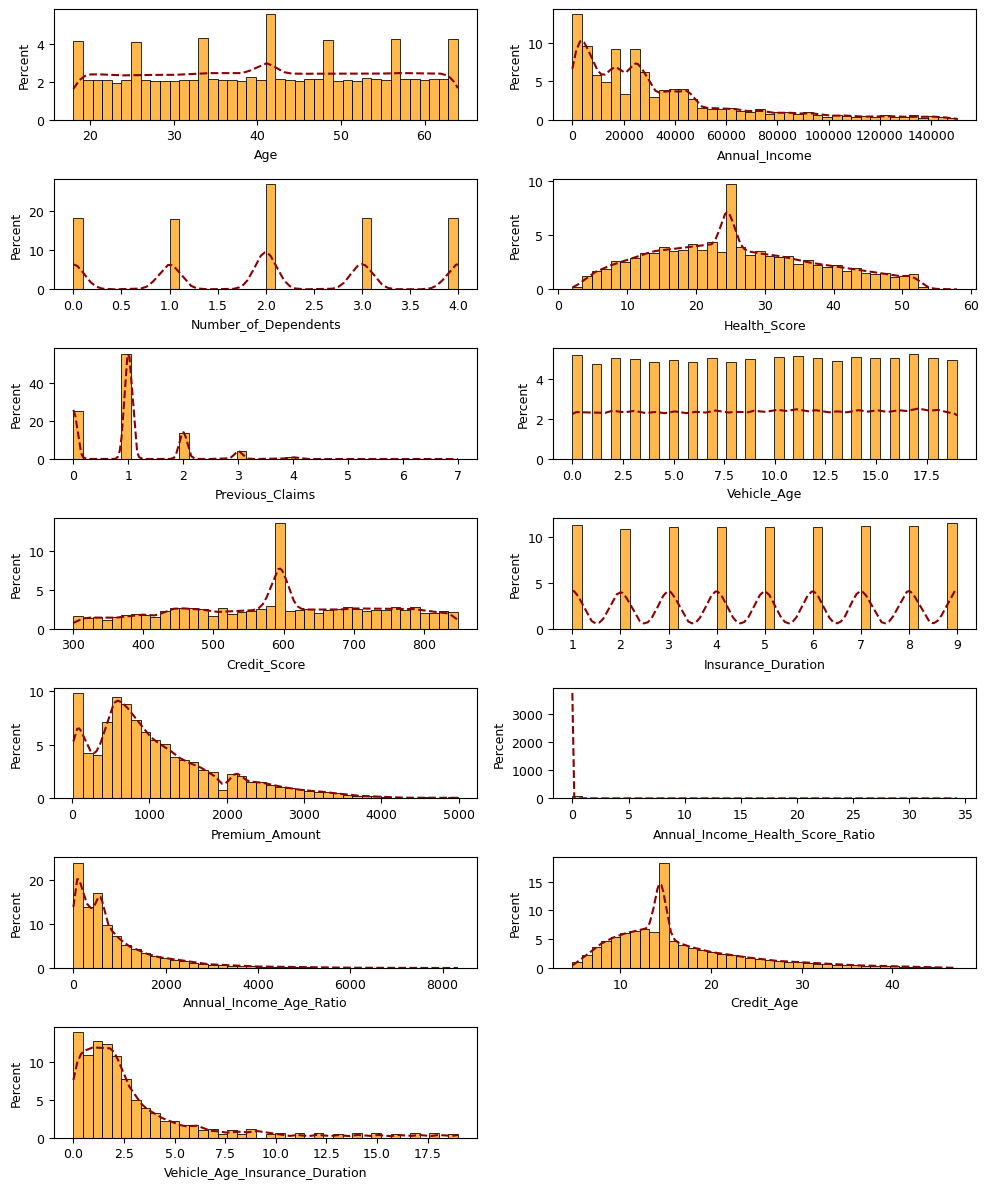

In [17]:
fig = plt.figure(figsize=(10, 12))

for i, feature in enumerate(num_vars):
    ax = fig.add_subplot(7, 2, i + 1)
    sns.histplot(
        df_sample_n[feature],
        stat="percent",
        kde=True,
        bins=40,
        alpha=0.7,
        color="#ff9a00",
        line_kws={"lw": 1.5, "linestyle": "dashed"},
    ).lines[0].set_color("darkred")
    plt.tick_params(axis="both", labelsize=9)
    plt.ylabel("Percent", fontsize=9)
    plt.xlabel(feature, fontsize=9)


fig.tight_layout()
plt.show()

### Target Variable Distribution

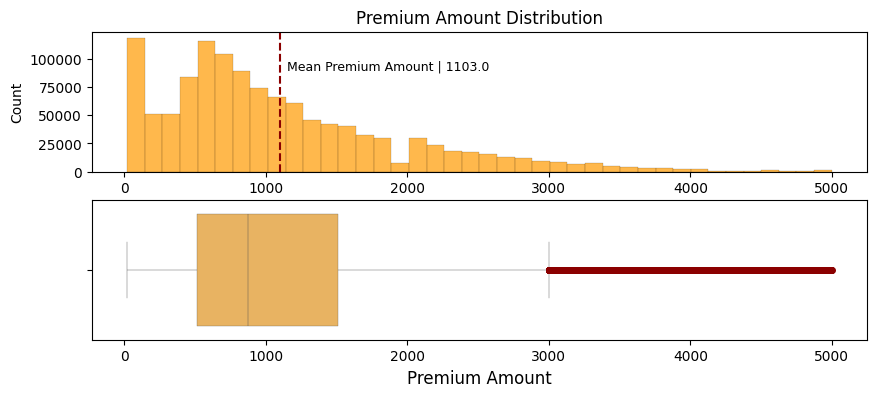

In [18]:
mean_premium_amount = train_df[["Premium_Amount"]].mean().squeeze()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 4))

sns.histplot(data=train_df, x="Premium_Amount", color="#ff9a00", bins=40, alpha=0.7, lw=0.1, ax=ax1)

sns.boxplot(
    data=train_df,
    x="Premium_Amount",
    color="#ff9a00",
    linewidth=0.3,
    flierprops=dict(
        marker="o", markersize=4, markerfacecolor="darkred", markeredgecolor="darkred"
    ),
    boxprops=dict(alpha=0.7),
    ax=ax2,
)
ax2.set_title("")
ax2.set_xlabel("Premium Amount", fontsize=12)

ax1.set_title("Premium Amount Distribution", fontsize=12)
ax1.set_xlabel("")

ax1.axvline(x=mean_premium_amount, color="darkred", ls="--", lw=1.5)
ax1.text(
    mean_premium_amount + 50,
    90000,
    "Mean Premium Amount | " + str(mean_premium_amount.round(0)),
    fontsize=9,
    color="#000000",
)

plt.show()

### Age Distribution

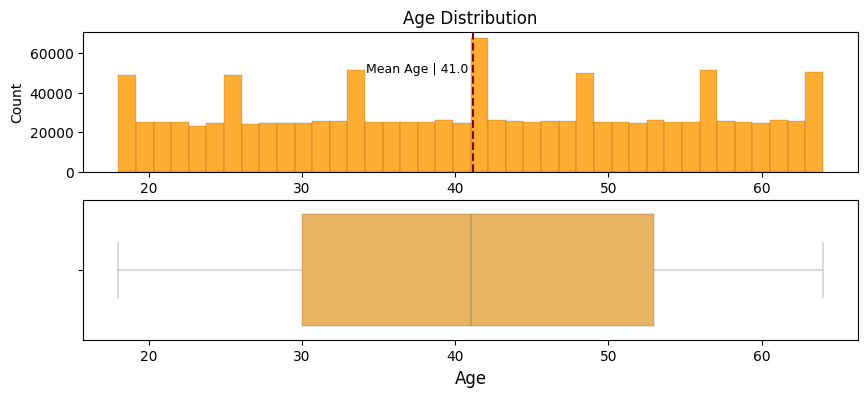

In [19]:
mean_age = train_df[["Age"]].mean().squeeze()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 4))

sns.histplot(
    data=train_df, x="Age", color="#ff9a00", bins=40, alpha=0.8, lw=0.1, ax=ax1
)

sns.boxplot(
    data=train_df,
    x="Age",
    color="#ff9a00",
    linewidth=0.3,
    flierprops=dict(
        marker="o", markersize=4, markerfacecolor="#107dac", markeredgecolor="#107dac"
    ),
    boxprops=dict(alpha=0.7),
    ax=ax2,
)
ax2.set_title("")
ax2.set_xlabel("Age", fontsize=12)

ax1.set_title("Age Distribution", fontsize=12)
ax1.set_xlabel("")

ax1.axvline(x=mean_age, color="darkred", ls="--", lw=1.5)
ax1.text(
    mean_age - 7,
    50000,
    "Mean Age | " + str(mean_age.round(0)),
    fontsize=9,
    color="#000000",
)

plt.show()

## Categorical Variables Distributions

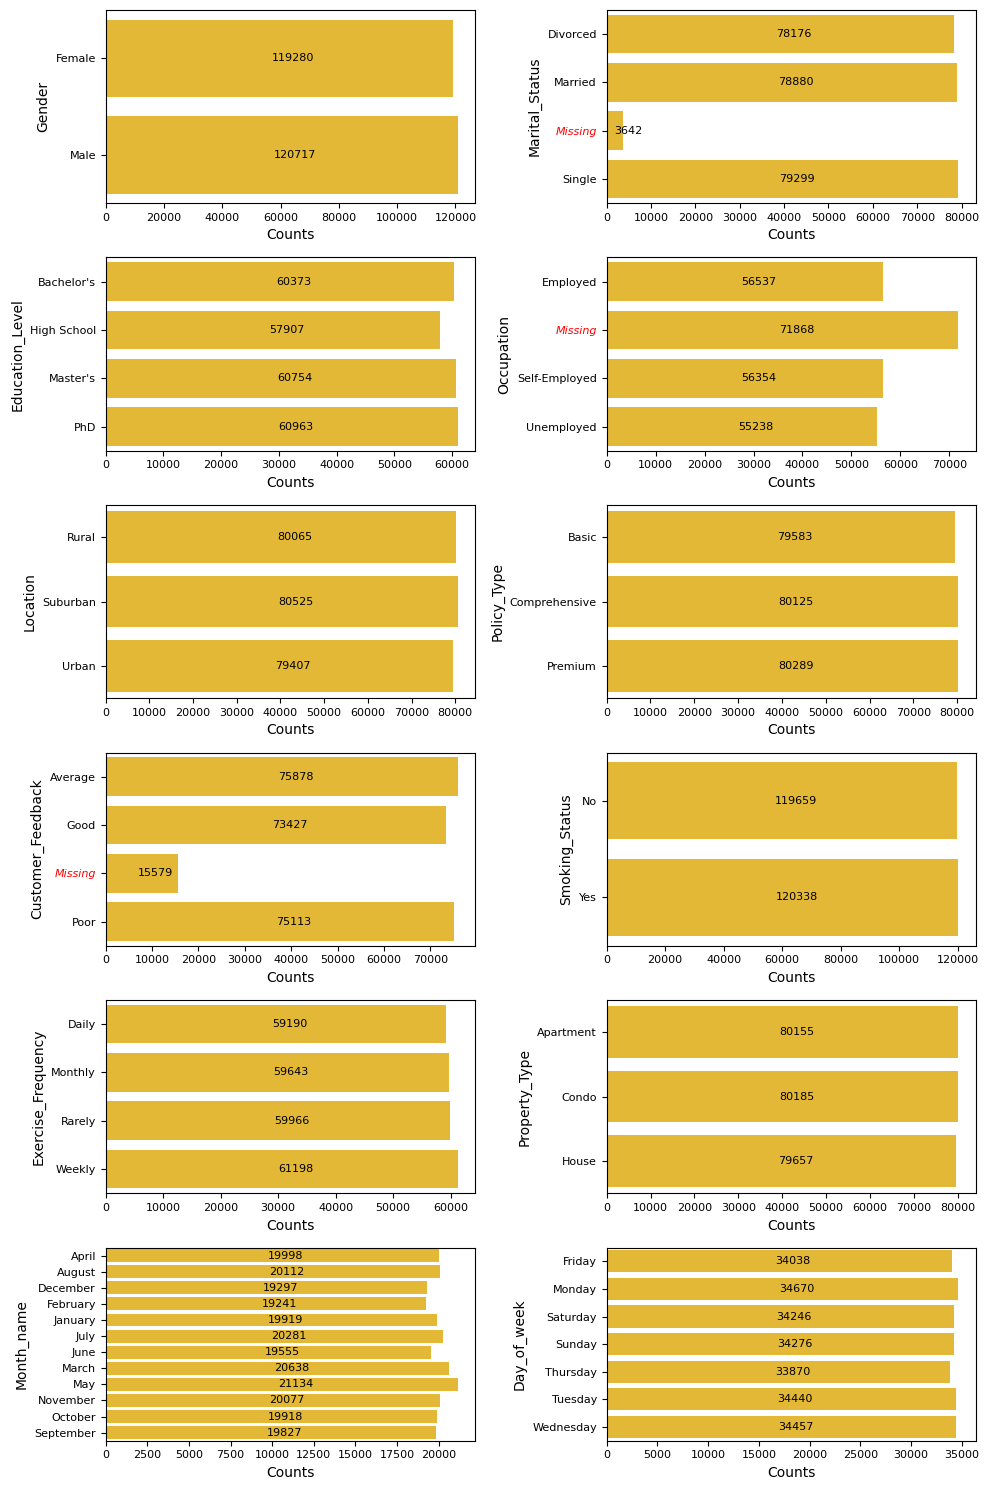

In [20]:
fig = plt.figure(figsize=(10, 15))

for i, feature in enumerate(np.delete(obj_vars, 6)):
    ax = fig.add_subplot(6, 2, i + 1)
    df_temp = df_sample_n[feature].value_counts().nlargest(20).reset_index()
    sns.barplot(df_temp, y=feature, x="count", color="#ffc100", orient="h", alpha=0.9)
    ax.bar_label(
        ax.containers[0], label_type="center", padding=10, color="black", fontsize=8
    )
    [
        (lab.set_color("r"), lab.set_fontsize(10), lab.set_fontstyle('italic'))
        for lab in ax.get_yticklabels()
        if lab.get_text() == "Missing"
    ]
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xlabel("Counts", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)


fig.tight_layout()
plt.show()

### All categorical variables are desperately Balanced!! I will take one of them for closer look! lets take Gender!

## By Gender

In [21]:
def by_gender (x_var, sel_rotation = 0, sel_aspect = 2.5):
    gs = sns.catplot(
    data=df_sample_n,
    x= x_var,
    kind="count",
    hue="Gender",
    height=2.5,
    aspect=sel_aspect,
    sharey=False,
    #col_wrap=2,
    palette=gender_color,
    legend_out=False,
    legend="auto",
    width=0.5,
)
    for ax in gs.axes.ravel():
        for i in ax.containers:
            ax.bar_label(i, label_type="edge", fontsize=7, padding=3, rotation=sel_rotation)
            ax.set_xlabel("", fontsize=12)
            ax.set_ylabel("", fontsize=12)
            ax.tick_params(axis="both", labelsize=8)
            gs.set_titles(size=8)
            gs.legend.remove()
            [
        (lab.set_color("r"), lab.set_fontsize(10), lab.set_fontstyle('italic'))
        for lab in ax.get_xticklabels()
        if lab.get_text() == "Missing"
        ]
        plt.show

### Marital Status by Gender

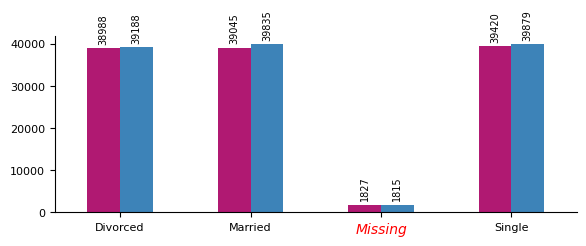

In [22]:
by_gender("Marital_Status", sel_rotation = 90)

### Education Level by Gender

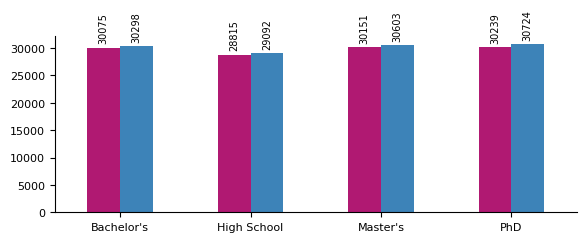

In [23]:
by_gender("Education_Level", sel_rotation = 90)

### Smoking Status by Gender

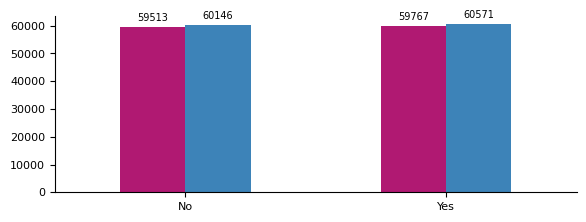

In [24]:
by_gender("Smoking_Status")

### Policy Type by Gender

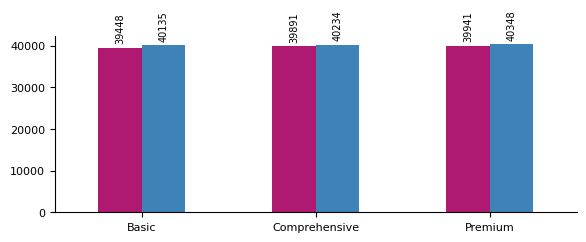

In [25]:
by_gender("Policy_Type",  sel_rotation = 90)

### Gender by Date | Year | Month | Day

### Policy Start Date | Year

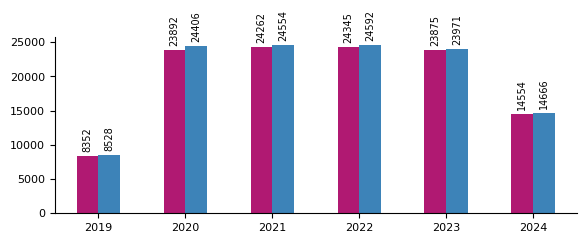

In [26]:
by_gender("Year", sel_rotation = 90)

### Policy Start Date | Month

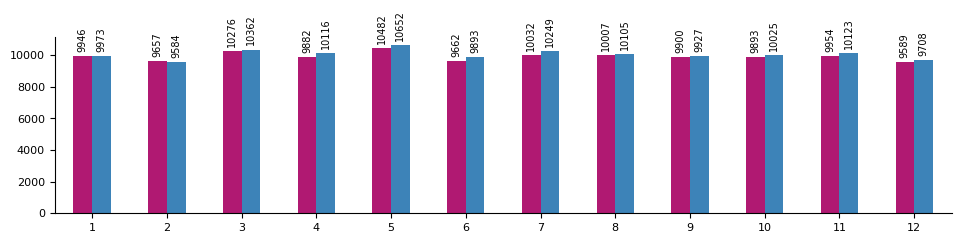

In [27]:
by_gender("Month", sel_rotation = 90, sel_aspect = 4)

### Policy Start Date | Day

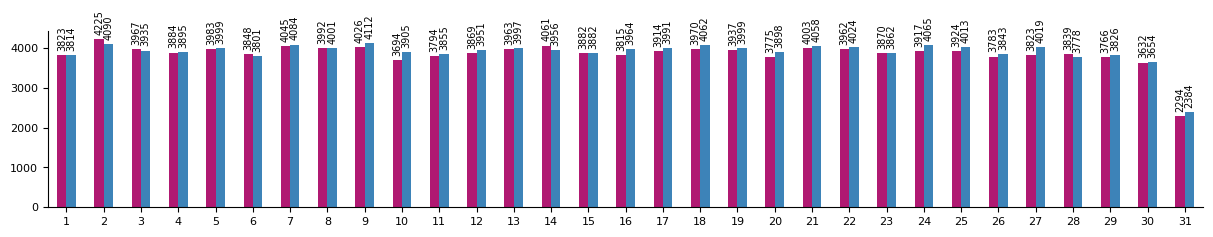

In [28]:
by_gender("Day", sel_rotation = 90, sel_aspect = 5)

#### WOW! I think Gender Category will not be an important feature.

## Premium Amount and Annual Income

In [29]:
df_sample_01 = train_df.groupby("Premium_Amount").sample(frac=0.01, random_state= 8).reset_index(drop = True)

def PAAI(hue_var):
    
    sns.lmplot(
        data=df_sample_01,
        x="Premium_Amount",
        y="Annual_Income",
        height=4,
        aspect=2,
        hue=hue_var,
        scatter_kws={"s": 8, "alpha": 0.3},
        line_kws={"linewidth": 1},
    )
    plt.title(f"Premium Amount and Annual Income VS {hue_var}", fontsize=14, color="#0a2e4f")
    plt.show()

### Premium Amount and Annual Income VS Year

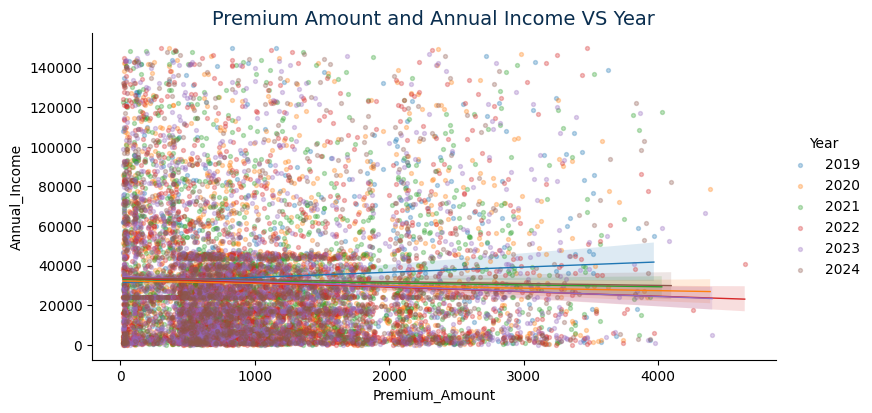

In [30]:
PAAI("Year")

### Premium Amount and Annual Income VS Month

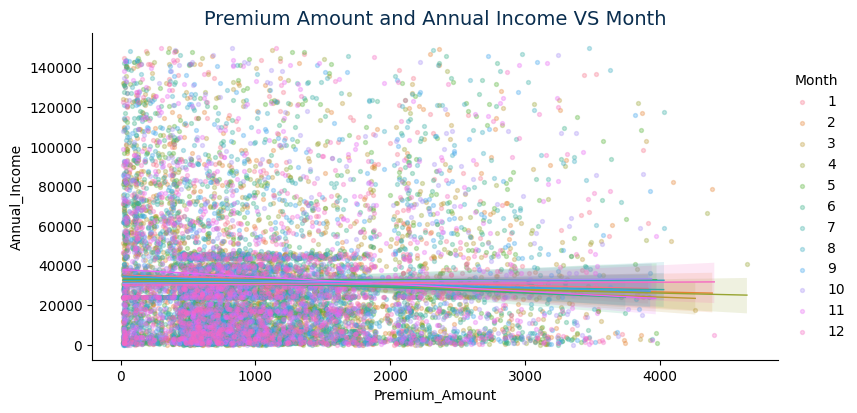

In [31]:
PAAI("Month")

### Premium Amount and Annual Income VS Smoking Status

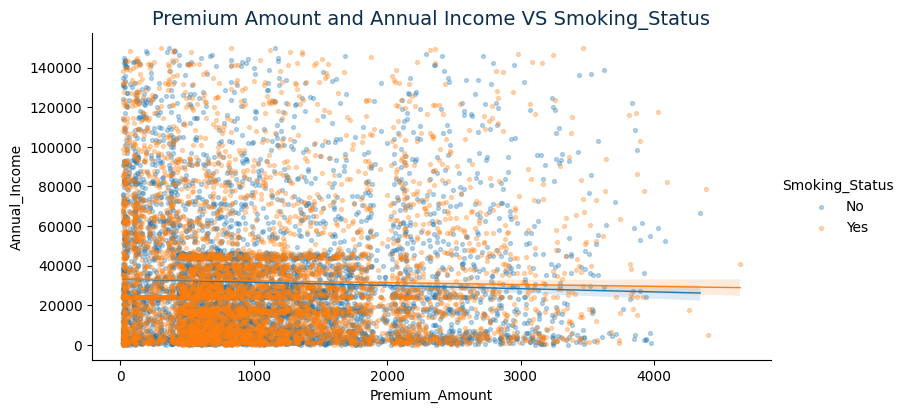

In [32]:
PAAI("Smoking_Status")

 ### Premium Amount and Annual Income VS Education Level

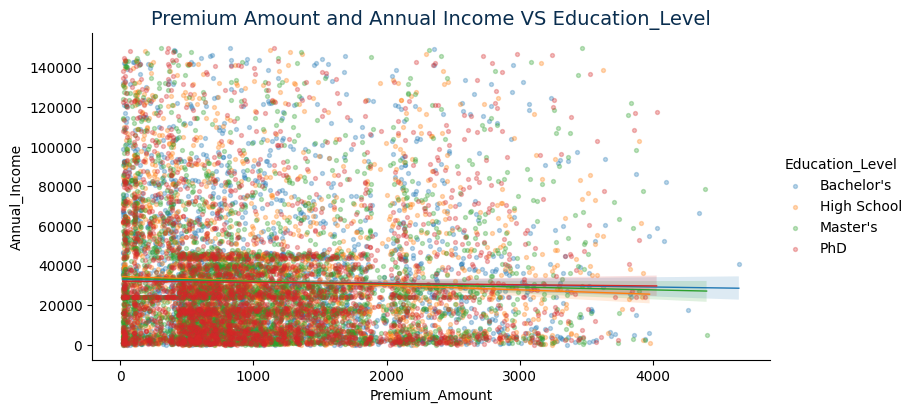

In [33]:
PAAI("Education_Level")

## Number of policies | Time series

### Number of policies by Marital Status

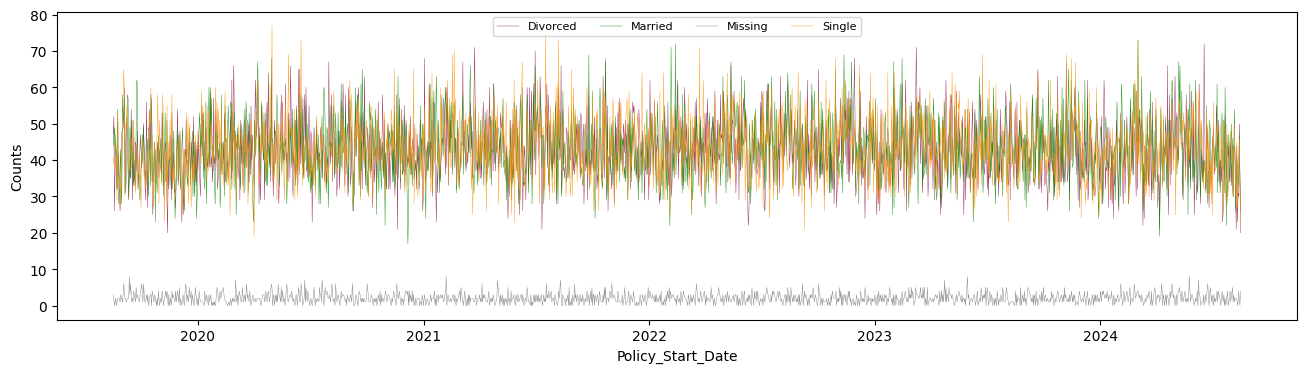

In [34]:
ts_df = (
    df_sample_n.groupby(["Policy_Start_Date", "Marital_Status"])["Policy_Start_Date"]
    .count()
    .reset_index(name="Counts")
)

plt.figure(figsize=(16, 4))
sns.lineplot(
    data=ts_df,
    x="Policy_Start_Date",
    y="Counts",
    hue="Marital_Status",
    errorbar=None,
    palette=marital_status_color,
    linewidth=0.3,
)
plt.legend(ncols=4, fontsize=8, loc="upper center")
plt.show()

### Even NAs are Balanced :)

### Number of policies by Smoking Status

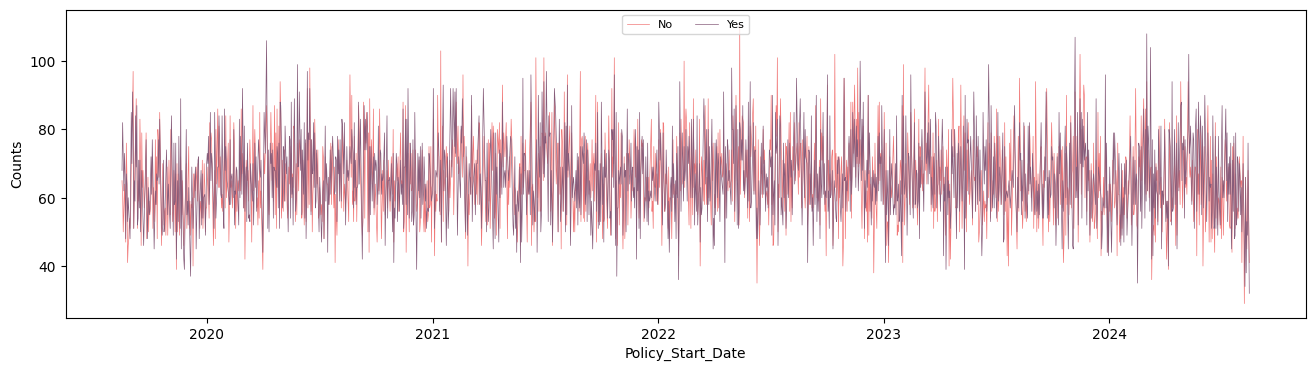

In [35]:
ts_df = (
    df_sample_n.groupby(["Policy_Start_Date", "Smoking_Status"])["Policy_Start_Date"]
    .count()
    .reset_index(name="Counts")
)
plt.figure(figsize=(16, 4))
sns.lineplot(
    data=ts_df,
    x="Policy_Start_Date",
    y="Counts",
    hue="Smoking_Status",
    errorbar=None,
    palette=smoking_status_color,
    linewidth=0.5,
)
plt.legend(ncols=4, fontsize=8, loc="upper center")
plt.show()

### I think I have to stop here | all the same including Gender variable

### Correlation Matrix

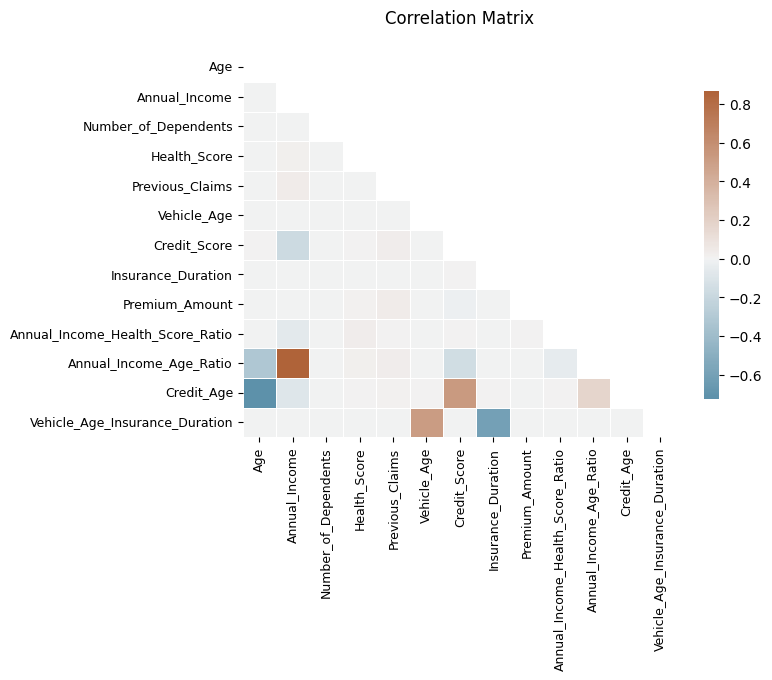

In [36]:

plt.style.use("default")
corr_mat = df_sample_n[num_vars].corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    corr_mat,
    mask=mask,
    cbar=True,
    cmap=cmap,
    center=0,
    square=False,
    annot=False,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix\n")
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

### Features Correlating | Premium Amount

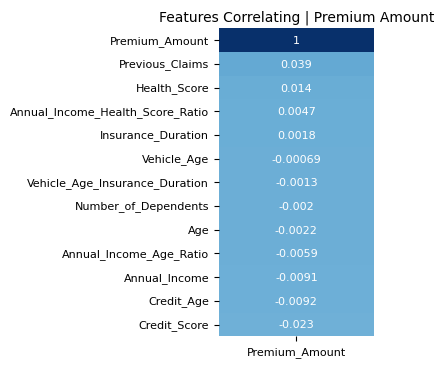

In [37]:
plt.figure(figsize=(2, 4))
corr_mat2 =  df_sample_n[num_vars].corr()
sns.heatmap(
    corr_mat2[["Premium_Amount"]].sort_values(by="Premium_Amount", ascending=False),
    vmin=-1,
    vmax=1,
    cbar=False,
    annot=True,
    cmap="Blues",
    annot_kws={"fontsize":8}
)
plt.title("Features Correlating | Premium Amount", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

 ## Model

### Data Transformation

In [38]:
train_df_fm = train_df.drop(columns=["Policy_Start_Date"], axis=1)
test_df = test_df.drop(columns=["Policy_Start_Date"], axis=1)


for i in test_num_vars:
    train_df_fm[i] = np.log1p(train_df_fm[i])
                        

X = train_df_fm.drop(columns=["Premium_Amount"], axis=1)
y = np.log(train_df_fm["Premium_Amount"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)



##  Lightgbm Regressor

### Hyperparameter Tuning (Optuna)

In [39]:
def xgb_objective(trial):

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "enable_categorical": True,
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 7, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),  # Similar to bagging_fraction
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.88),  # Similar to feature_fraction
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),  # Regularization
        "lambda": trial.suggest_float("lambda", 0.03, 0.05),  # L2 regularization
        "alpha": trial.suggest_float("alpha", 0.07, 0.09),  # L1 regularization
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "tree_method": "hist",  # Optimized tree method
        "random_state": 1
    }

    xgb_model = XGBRegressor(**xgb_params)

    xgb_model.fit(X_train, y_train)
    y_pred = np.exp(xgb_model.predict(X_test))
    print(rmsle(np.exp(y_test), y_pred))


    return rmsle(np.exp(y_test), y_pred)


### Create a study object | optimization

In [40]:
study_XGBM = optuna.create_study(study_name="XGBM_Insurance", direction="minimize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_XGBM.optimize(xgb_objective, n_trials=5, show_progress_bar=True)

[I 2025-04-05 16:37:21,958] A new study created in memory with name: XGBM_Insurance
Best trial: 0. Best value: 1.05532:  20%|██        | 1/5 [01:24<05:37, 84.33s/it]

1.0553246792924909


Best trial: 1. Best value: 1.04784:  40%|████      | 2/5 [01:45<02:21, 47.24s/it]

1.0478419705887845


Best trial: 1. Best value: 1.04784:  60%|██████    | 3/5 [02:49<01:50, 55.00s/it]

1.0524402951115444


Best trial: 3. Best value: 1.04762:  80%|████████  | 4/5 [03:01<00:38, 38.05s/it]

1.0476174249263168


Best trial: 3. Best value: 1.04762: 100%|██████████| 5/5 [03:18<00:00, 39.77s/it]

1.0490022950352507


### Best trial

In [41]:
print("Best trial:", study_XGBM.best_trial)

Best trial: FrozenTrial(number=3, state=1, values=[1.0476174249263168], datetime_start=datetime.datetime(2025, 4, 5, 16, 40, 11, 810884), datetime_complete=datetime.datetime(2025, 4, 5, 16, 40, 23, 881333), params={'max_depth': 12, 'learning_rate': 0.018016478251091546, 'subsample': 0.631384612317387, 'colsample_bytree': 0.8713202490006425, 'gamma': 3.8039743259625283, 'lambda': 0.03477973764904808, 'alpha': 0.08482946900485708, 'min_child_weight': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=25, log=False, low=7, step=1), 'learning_rate': FloatDistribution(high=0.03, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=0.9, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=0.88, log=False, low=0.7, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'lambda': FloatDistribution(high=0.05, log=False, low=0.03, step=None), 'alpha': FloatDistribution(high=0

### Best parameters

In [42]:
print("Best parameters:", study_XGBM.best_params)

Best parameters: {'max_depth': 12, 'learning_rate': 0.018016478251091546, 'subsample': 0.631384612317387, 'colsample_bytree': 0.8713202490006425, 'gamma': 3.8039743259625283, 'lambda': 0.03477973764904808, 'alpha': 0.08482946900485708, 'min_child_weight': 5}


### Visualization optimization history

In [43]:
import plotly
print(plotly.__version__)  # Should print a version number


6.0.1


In [44]:
fig = optuna.visualization.plot_optimization_history(study_XGBM)
fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor='#e9eff6',
    paper_bgcolor='#f5fbf5',
)
fig.update_xaxes(color = "darkgreen")
fig.update_traces(marker_color='green')

### Visualization parameters importances

In [45]:
fig = optuna.visualization.plot_param_importances(study_XGBM)
fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor='#e9eff6',
    paper_bgcolor='#f5fbf5',
)
fig.update_xaxes(color = "darkgreen")
fig.update_traces(marker_color='green')

### Visualization slice

In [46]:
import optuna.visualization as vis

fig = vis.plot_slice(
    study_XGBM,
    params=[
        "max_depth",
        "learning_rate",
        "subsample",
        "colsample_bytree",
        "gamma",
        "lambda",             # L2 regularization
        "alpha",              # L1 regularization
        "min_child_weight",
    ],
)

fig.update_layout(
    font_family="Courier New",
    font_size=12,
    title_font_family="Times New Roman",
    title_font_color="steelblue",
    legend_title_font_color="black",
    plot_bgcolor="#e9eff6",
    paper_bgcolor="#f5fbf5",
)

fig.update_xaxes(color="darkgreen")


## Train the model

In [ ]:
from xgboost import XGBRegressor

xgbm_final = XGBRegressor(
    **study_XGBM.best_params,
    objective="reg:squarederror",       # Correct regression objective
    eval_metric="rmse",                 # Optional but recommended for regression
    n_estimators=500,                   # Override number of boosting rounds
    random_state=1,
    enable_categorical=True,            # Important for category dtype support
    tree_method="hist",                 # Required for enable_categorical
    verbosity=0                         # Instead of verbose=-1
)

xgbm_final.fit(X_train, y_train)

y_pred = np.exp(xgbm_final.predict(X_test))
print("RMSLE:", rmsle(np.exp(y_test), y_pred))


RMSLE: 1.0475797122647301


## feature gain

<Figure size 1200x600 with 0 Axes>

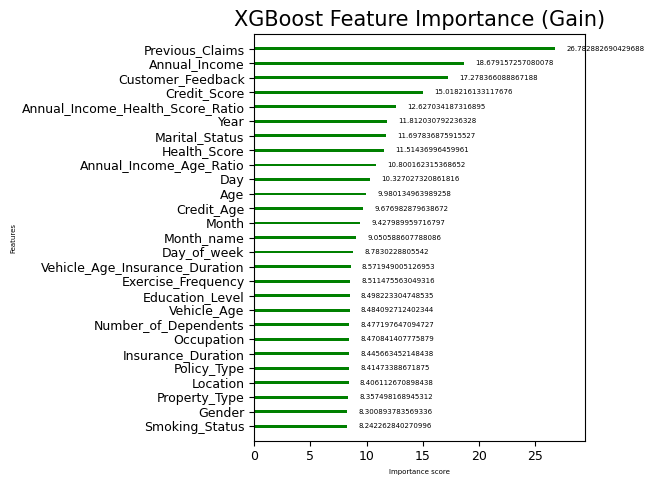

In [58]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.rcParams['font.size'] = 5
plt.figure(figsize=(12, 6))  # Set figure size here

xgb.plot_importance(
    xgbm_final,
    importance_type="gain",
    grid=False,
    color="green"
)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title("XGBoost Feature Importance (Gain)", fontsize=15)
plt.tight_layout()
plt.show()

# Reset to default if needed
plt.rcParams.update(plt.rcParamsDefault)


## SHAP Values

### Sampling for claculating SHAP values

In [67]:
train_df_shap = train_df.drop(columns=["Policy_Start_Date"], axis=1)
shap_df = (
    train_df_shap.groupby("Premium_Amount")[train_df_shap.columns.tolist()]
    .apply(lambda x: x.sample(frac=0.1), include_groups=True)
    .reset_index(drop=True)
    .copy()
)

############################

X_shap = shap_df.drop(["Premium_Amount"], axis=1)

# Convert all categorical features to string first (if needed), then use one-hot encoding or label encoding
X_shap_encoded = pd.get_dummies(X_shap, drop_first=True)

y_shap = np.log(shap_df["Premium_Amount"])
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X_shap_encoded, y_shap, test_size=0.2, random_state=1
)


############################

xgbm_interp = XGBRegressor(
    **study_XGBM.best_params,
    objective="reg:squarederror",  # for regression
    n_estimators=500,
    random_state=1,
    verbosity=0
)
xgbm_interp.fit(X_train_shap, y_train_shap)

shap.initjs()
explainer = shap.TreeExplainer(xgbm_interp)
shap_values = explainer(X_train_shap)

### SHAP Summary | layered_violin

/home/kishore/miniconda3/lib/python3.12/site-packages/shap/plots/_violin.py:304: UserWarning:

Not enough data in bin #8 for feature Previous_Claims, so it'll be ignored. Try increasing the number of records to plot.



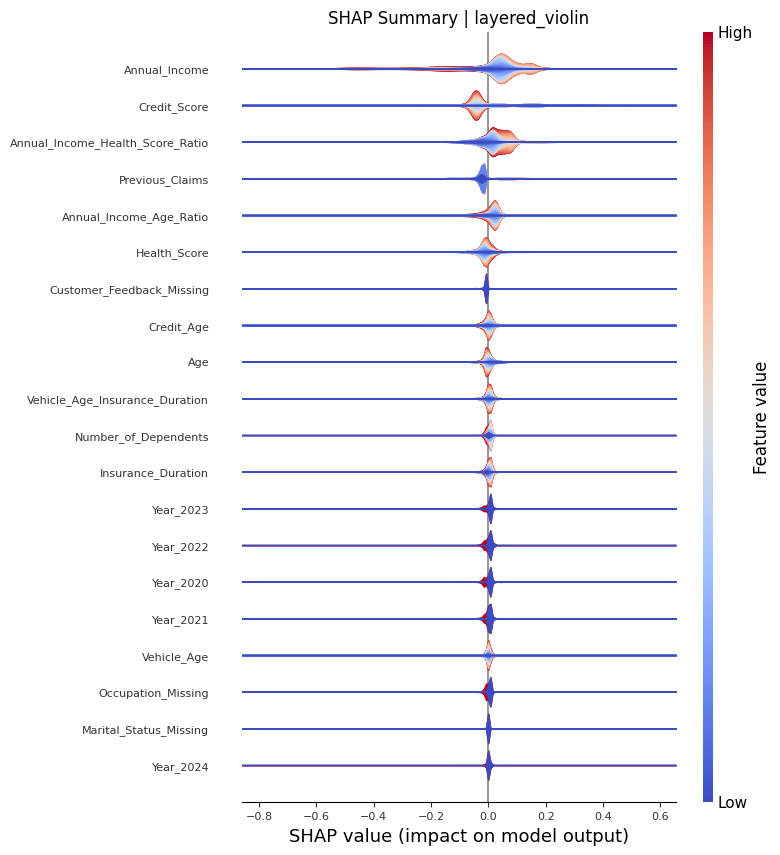

In [68]:
shap.plots.violin(
    shap_values,
    plot_type="layered_violin",
    show=False,
)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(10)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
ax.set_title("SHAP Summary | layered_violin", fontsize=12)
plt.show()

### Feature Importance | SHAP

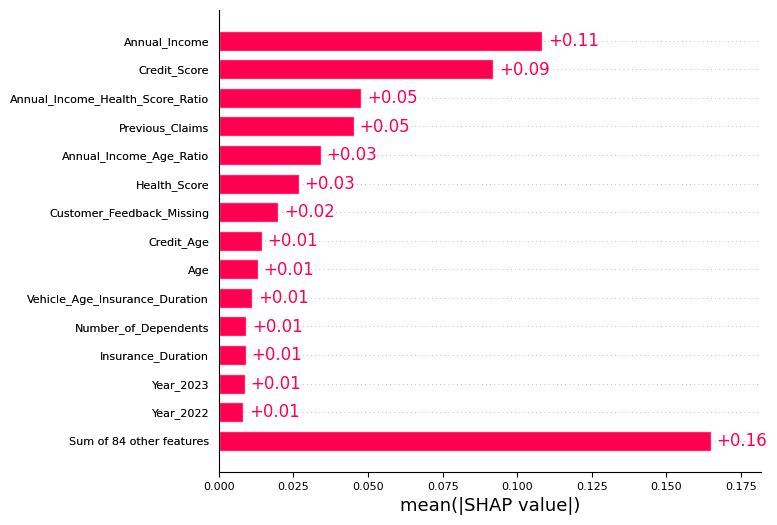

In [69]:
shap.plots.bar(shap_values, max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(6)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
plt.show()

### Waterfall Plot

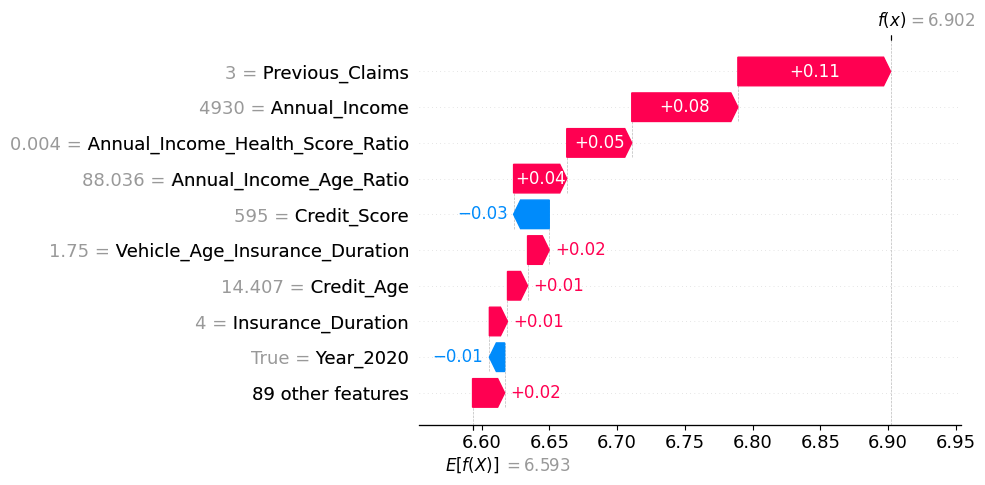

In [70]:
index = 2
shap.plots.waterfall(shap_values[index], show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.show()

### Force Plot

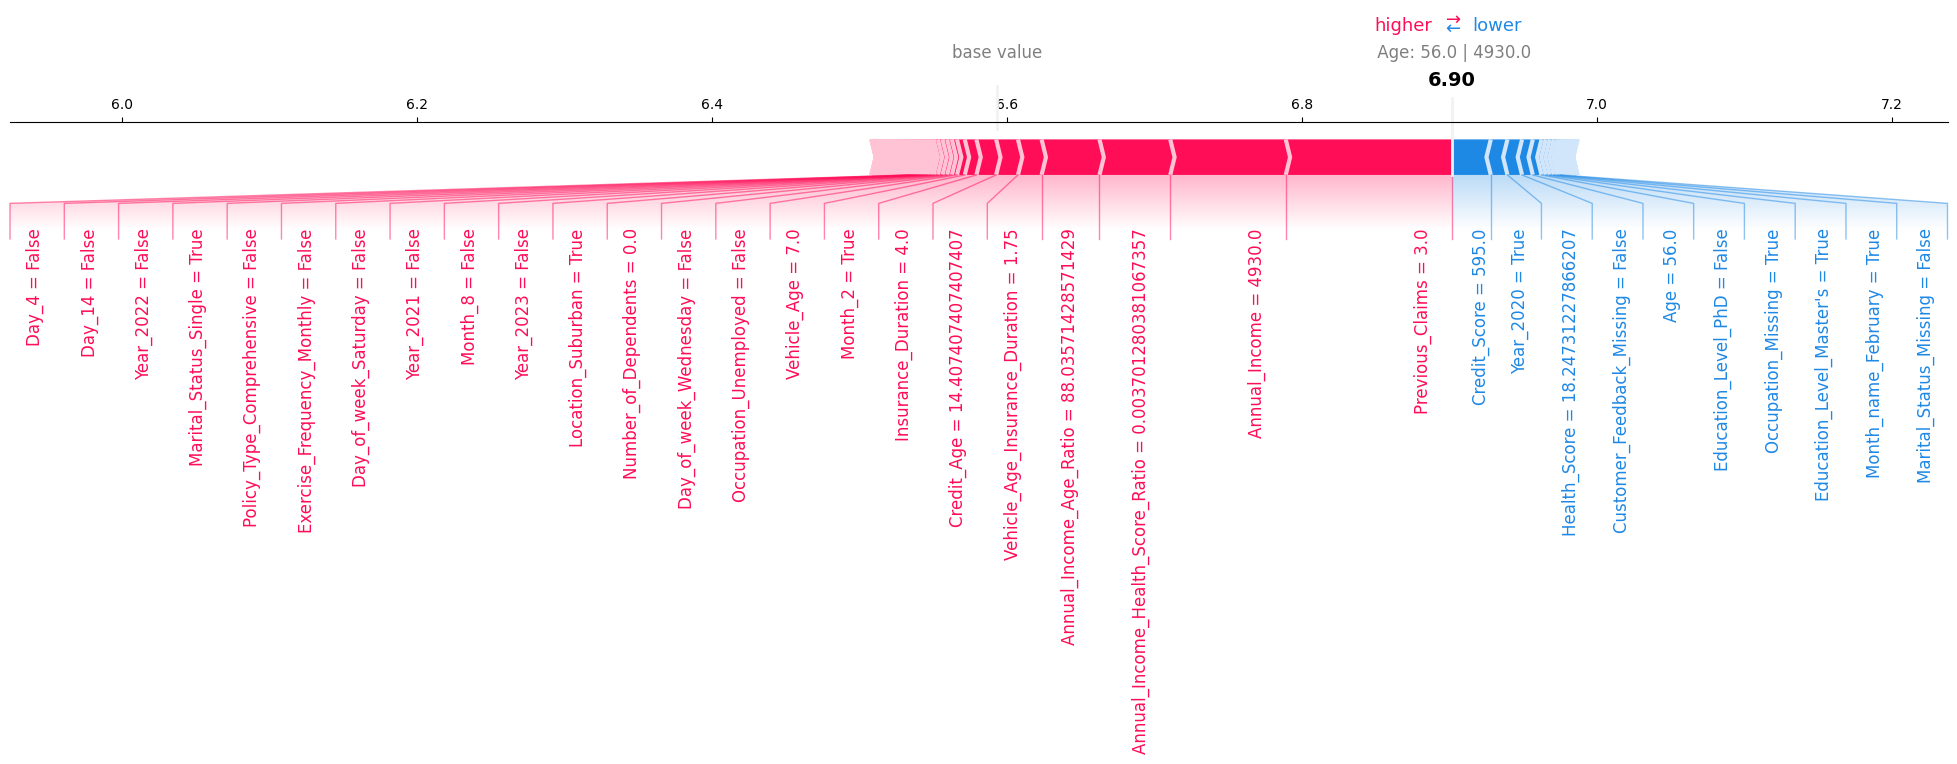

In [71]:

shap.plots.force(
    shap_values[index],
    text_rotation=90,
    matplotlib=True,
    figsize=(25, 3),
    contribution_threshold=0.005,
    out_names=f" Age: {shap_values[index].data[0]} | {shap_values[index].data[1]}",
)

## Make predictions on Test Dataset

In [73]:

for i in test_num_vars:
    test_df[i] = np.log1p(test_df[i])



y_pred_test = np.exp(xgbm_final.predict(test_df))
y_pred_test

array([697.6783 , 431.25476, 433.59653, ..., 376.42108, 379.41806,
       490.68866], dtype=float32)

## Submission

In [74]:
sample_submission["Premium Amount"] =  y_pred_test

sample_submission.to_csv('submission.csv',index=False)
sample_submission

,id,Premium Amount
0,1200000,697.678284
1,1200001,431.254761
2,1200002,433.596527
3,1200003,567.065369
4,1200004,483.113007
...,...,...
799995,1999995,374.231171
799996,1999996,437.152771
799997,1999997,376.421082
799998,1999998,379.418060


## Premium Amount Distribution | Predictions

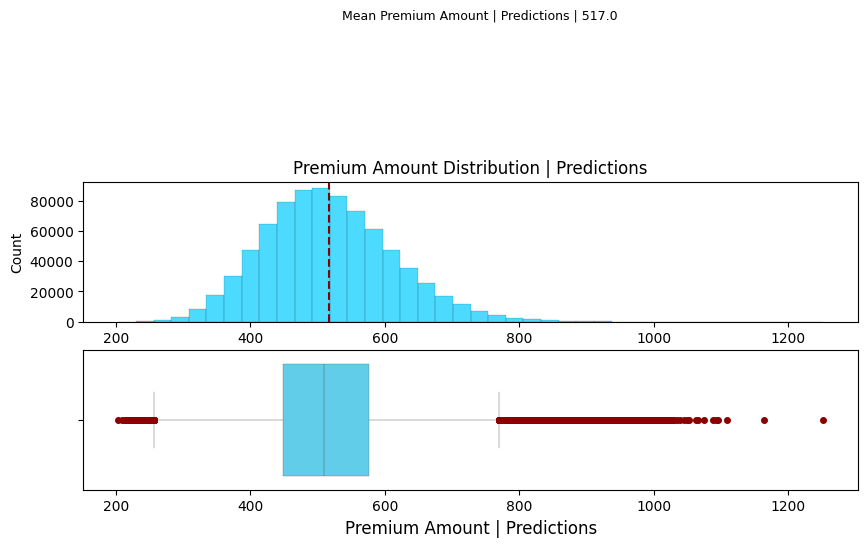

In [75]:
mean_premium_amount = sample_submission["Premium Amount"].mean().squeeze()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 4))

sns.histplot(
    data=sample_submission, x="Premium Amount", color="#00ccff", bins=40, alpha=0.7, lw=0.1, ax=ax1
)

sns.boxplot(
    data=sample_submission,
    x="Premium Amount",
    color="#00ccff",
    linewidth=0.3,
    flierprops=dict(
        marker="o", markersize=4, markerfacecolor="darkred", markeredgecolor="darkred"
    ),
    boxprops=dict(alpha=0.7),
    ax=ax2,
)
ax2.set_title("")
ax2.set_xlabel("Premium Amount | Predictions", fontsize=12)

ax1.set_title("Premium Amount Distribution | Predictions", fontsize=12)
ax1.set_xlabel("")

ax1.axvline(x=mean_premium_amount, color="darkred", ls="--", lw=1.5)
ax1.text(
    mean_premium_amount + 20,
    200000,
    "Mean Premium Amount | Predictions | " + str(mean_premium_amount.round(0)),
    fontsize=9,
    color="#000000",
)

plt.show()